# Kлассификация клиентов банка

Есть данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. В случае успеха в решении задачи вырастут доходы банка и улучшится понимание целевой аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача**: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

ОСНОВНЫЕ ЦЕЛИ:
- Исследовать данные.
- Выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка.
- Использовать разные инструменты для повышения качества прогноза.

ОСНОВНЫЕ ЭТАПЫ:
- Первичная обработка данных.
- Разведывательный анализ данных (EDA).
- Отбор и преобразование признаков.
- Решение задачи классификации: логистическая регрессия и решающие деревья.
- Решение задачи классификации: ансамбли моделей и построение прогноза.

ОПИСАНИЕ ДАННЫХ:

Информация о клиенте:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании)
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке.

In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna

## 1. Знакомство с данными, обработка пропусков и выбросов

In [695]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [696]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [697]:
df.isnull().sum() # смотрим на пустые значения

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

#### В признаке balance имеются пустые значения, преобразуем в вещественное число (float)

In [698]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace(',00 $','').replace(' ','').replace('$',''))
df['balance'] = df['balance'].astype(float)
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

#### Заменим пропуски в признаке balance на медианные значения по данному признаку

In [699]:
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

#### Обработуем пропуски в категориальных признаках: job и education, заменив их на модальные значения

In [700]:
# также есть пропуски в признаках: job и education в неявном виде.
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)


#### Работа с выбросами

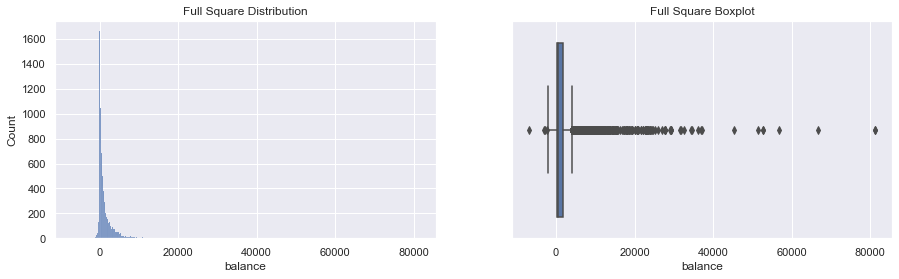

In [701]:
# Сделаем график по признаку balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

In [702]:
# Напишем функцию по методу Тьюки
def outliers_iqr(data, feature):
    """Функция получает на вход числовые данные, проводит оценку на наличие выбросов методом Тьюки и возвращает 
    исключенные данные и очищенные данные

    Args:
        data ([pd.DataFrame]): Входные данные в формате pd.DataFrame
        feature ([int, float]): Числовой признак, который подвергается анализу и чистке

    Returns:
        [pd.DataFrame]: Возвращает два pd.DataFrame с исключенными данными outliers и очищенными данными cleaned
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    print(f'25-й перцентиль: {quartile_1}')
    print(f'75-й перцентиль: {quartile_3}')
    print(f'IQR: {iqr}')
    print(f'Граници выбросов: [{lower_bound}, {upper_bound}]')
    print()
    return outliers, cleaned

# Применяем метод Тьюки
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

25-й перцентиль: 123.0
75-й перцентиль: 1699.0
IQR: 1576.0
Граници выбросов: [-2241.0, 4063.0]

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10104


In [703]:
# Зная границы выбросов можем отфильтровать данные
df = df[(df['balance'] >= -2241) & (df['balance'] <= 4063.0)]
df.shape

(10105, 17)

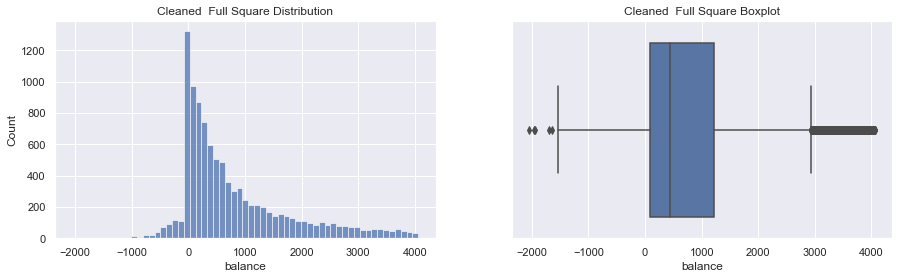

In [704]:
# Повторим график после очистки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Cleaned  Full Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned  Full Square Boxplot');

## 2. EDA Разведывательный анализ

### Задание 1

In [705]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [706]:
# Посмотрим распределение целевой переменны
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

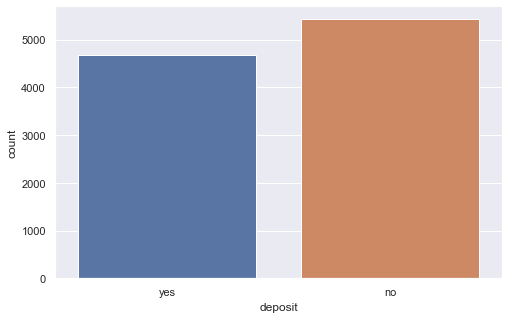

In [707]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='deposit');

In [708]:
# Посмотрим на описательную статистику для количественный переменных
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


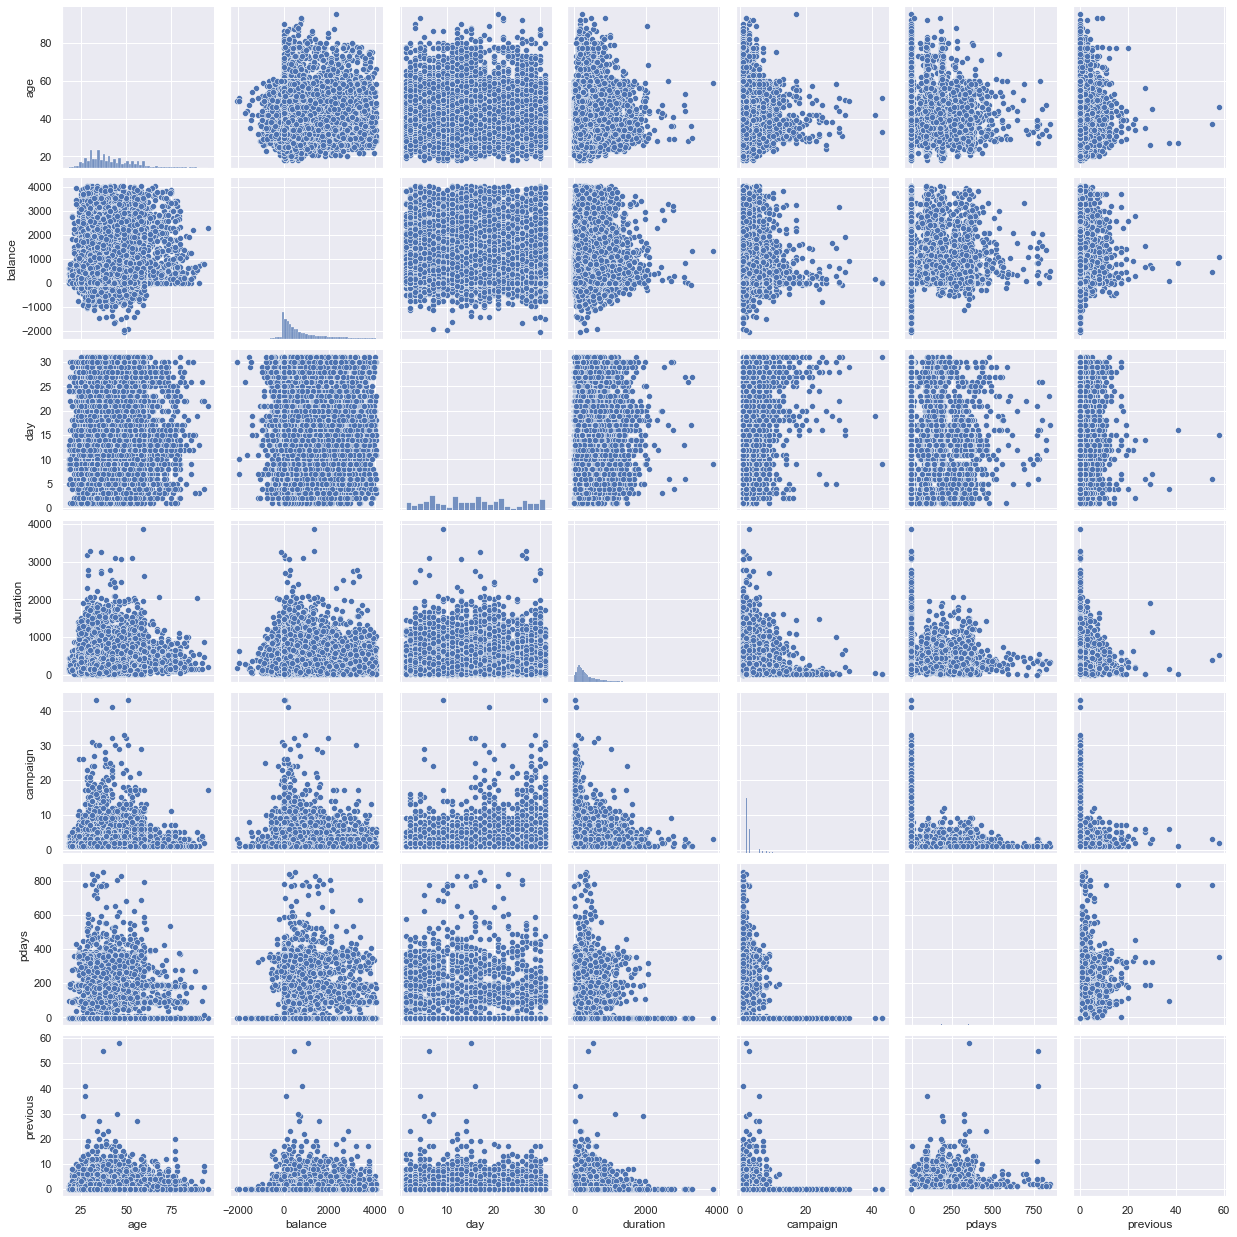

In [709]:
# Сделаем визуализацию
numeric_features = df.select_dtypes(include="number").columns
sns.pairplot(df[numeric_features])

- Есть счета с отрицательным балансом
- Средний возраст клиента 40 лет

#### Посмотрим на распределения категориальных признаков

In [710]:
# Описательная статистика для категориальных переменных
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


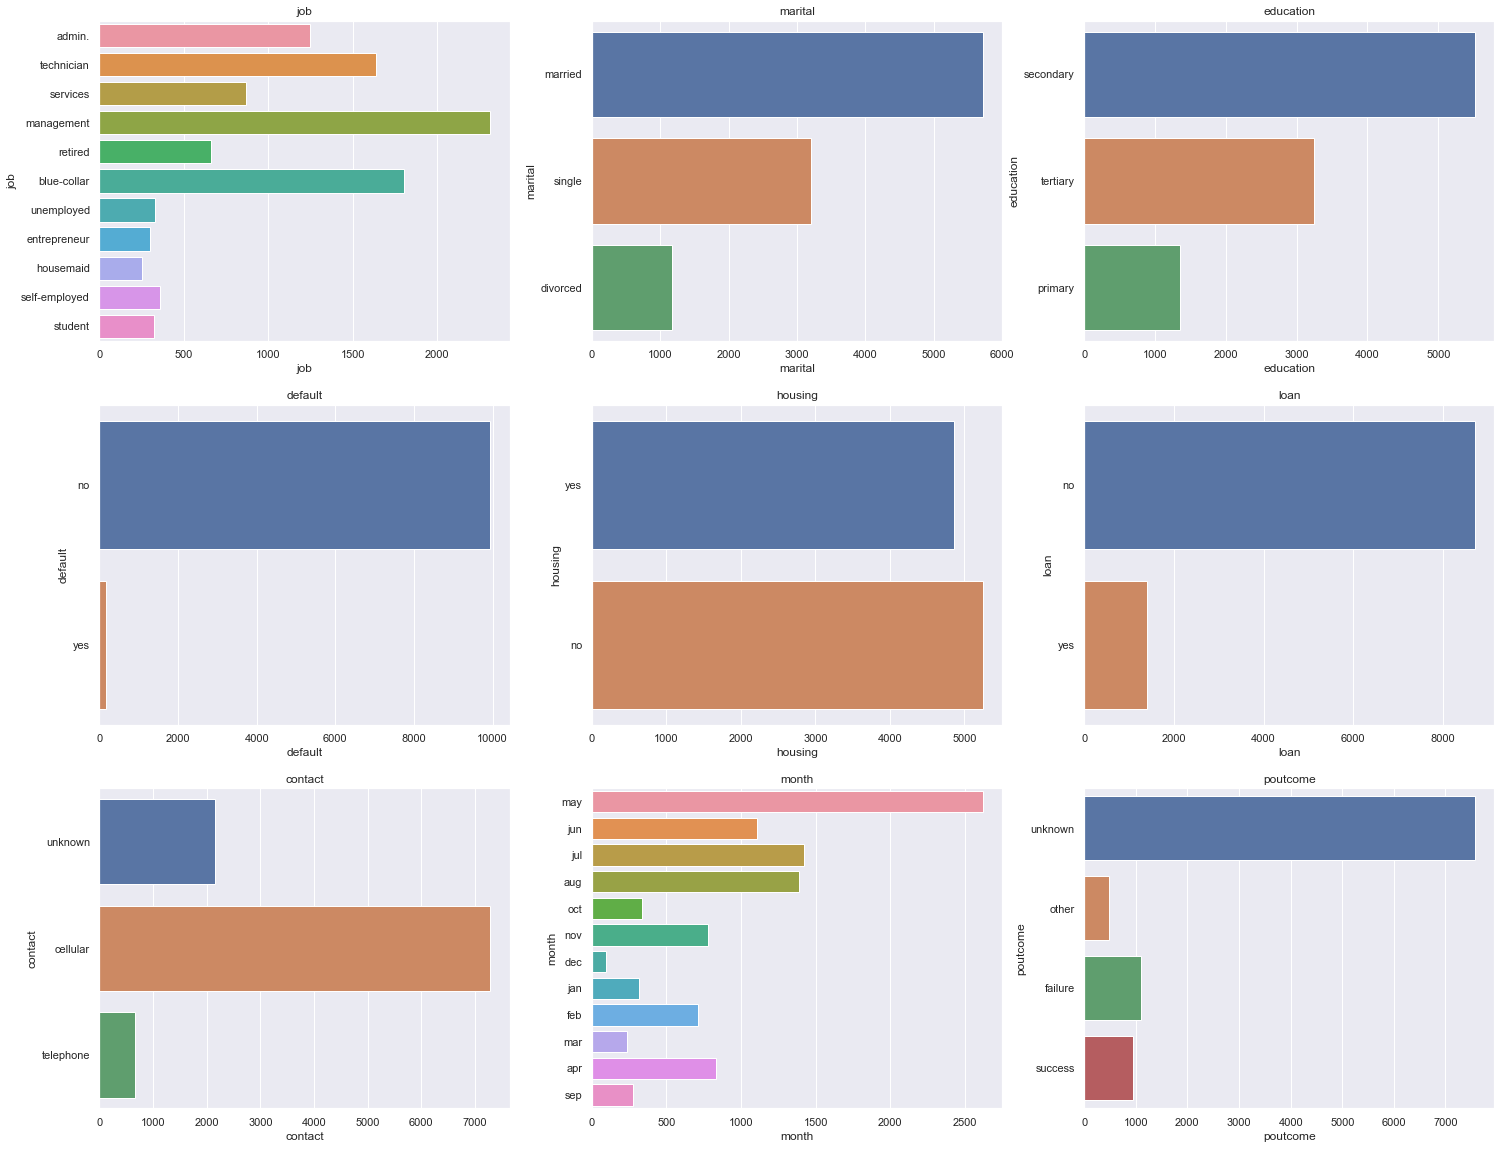

In [711]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
categorical_features=[f for f in df.columns if ((df[f].dtypes=='O') & (f not in ['deposit']))]
plt.figure(figsize=(25,20))
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(3,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


<AxesSubplot: xlabel='poutcome'>

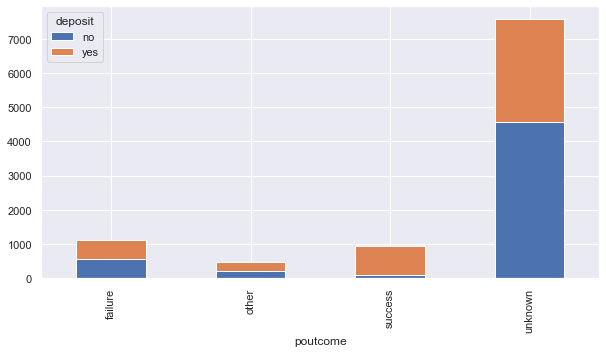

In [712]:
df_poutcome = df.groupby('poutcome')['deposit'].value_counts(normalize=False).round().unstack()
print(df_poutcome)
df_poutcome.plot(kind='bar', stacked='True')


Видно, что те, кто уже принимал предложение банка ранее, склонны принять предложение еще раз.



In [713]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
for i in np.unique(df.month):
    print(i, df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


В мае наблюдается самый высокий процент неудач (68%). Вторым "неудачным" месяцем является январь (61%)

Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже.



<AxesSubplot: xlabel='age_group', ylabel='count'>

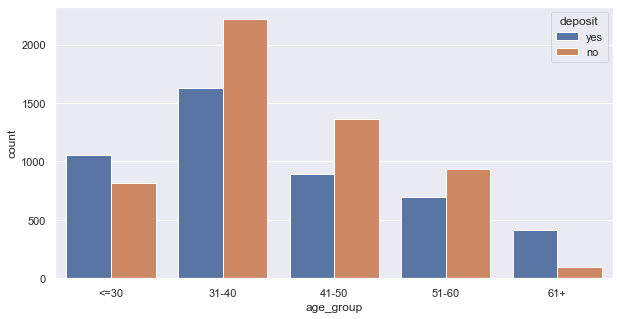

In [714]:
# определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,150], labels=['<=30','31-40','41-50','51-60','61+'])
fig = plt.figure(figsize=(10, 5))
sns.countplot(x="age_group", hue="deposit", data=df)

<AxesSubplot: xlabel='marital', ylabel='count'>

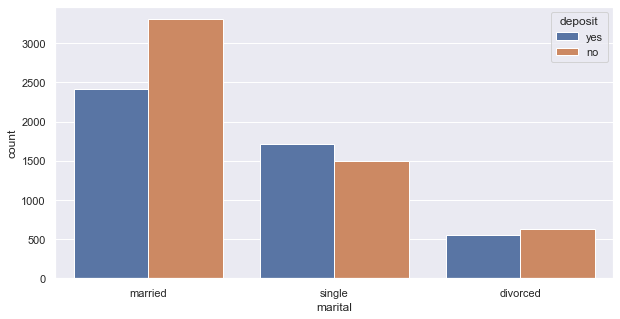

In [715]:
# Посмотрим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(x='marital', hue='deposit', data=df)

<AxesSubplot: xlabel='education', ylabel='count'>

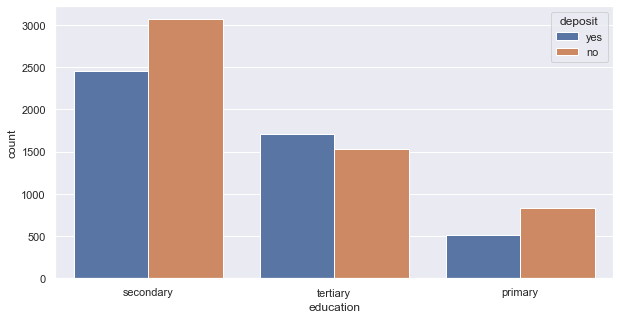

In [716]:
# Посмотрим визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(x='education', hue='deposit', data=df)

<AxesSubplot: xlabel='count', ylabel='job'>

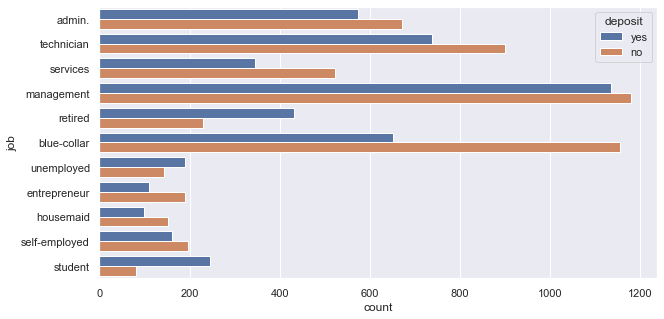

In [717]:
# Посмотрим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.set(rc={'figure.figsize':(10, 5)})
sns.countplot(y='job', hue='deposit', data=df)

Соотношение удач vs неудачи выше среди пенсионеров, безработных и студентов.

#### Посмотрим на пересечение категорий с точки зрения наличия депозита

In [718]:
# Посмотрим на визуализацию с семейным статусом
df['marital'].value_counts()

married     5715
single      3213
divorced    1177
Name: marital, dtype: int64

In [719]:
# Сделаем сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
pivot = df.pivot_table(values = ['age'], index=['deposit','education'], columns=['marital'], aggfunc=['count'])
pivot.columns.set_levels(['cnt'], level=1, inplace=True)
pivot.columns = pivot.columns.droplevel()
pivot

cnt               
marital           divorced married single
deposit education                        
no      primary         91     641    100
        secondary      370    1830    866
        tertiary       163     832    531
yes     primary         96     339     82
        secondary      283    1289    879
        tertiary       174     784    755

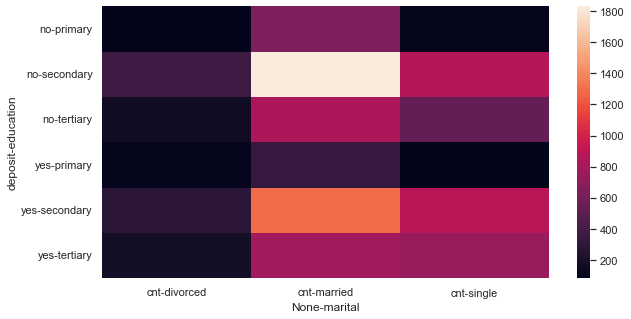

In [720]:
# Сделаем визуализацю
plt.figure(figsize=(10, 5))
ax = sns.heatmap(pivot)

Вывод: наиболее многочисленная группа - клиенты со средним образованием, женаты/замужем

## 3: Преобразование данных

#### Преобразуем уровень образования

In [721]:
# преобразуйте уровни образования с помошью метода LabelEncoder
df_education = LabelEncoder()  
df['education'] = df_education.fit_transform(df['education'])

11995

#### Преобразуем в бинарные переменные

In [723]:
# преобразуйте бинарные переменные в представление из нулей и единиц в новый признак age_group
df_age_group = LabelEncoder()
df["age_group"] = df_age_group.fit_transform(df["age_group"])

In [724]:
# Также преобразуем признак deposit
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,1,2


In [725]:
# Также с признаками default, housing, loan
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


#### Преобразуем в номинальные переменные

In [727]:
# создайте дамми-переменные для 'job', 'marital', 'contact', 'month', 'poutcome'
categorial_features  = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=categorial_features, prefix=categorial_features)
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


####  Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
1361,contact_unknown,contact_cellular,0.837885
459,pdays,poutcome_unknown,0.824031
1176,marital_married,marital_single,0.779038
505,previous,poutcome_unknown,0.628346
1941,poutcome_failure,pdays,0.608719
2112,poutcome_unknown,poutcome_failure,0.606736
2069,poutcome_success,poutcome_unknown,0.555044
18,age,job_retired,0.545524
63,education,job_management,0.518735
424,pdays,previous,0.513708


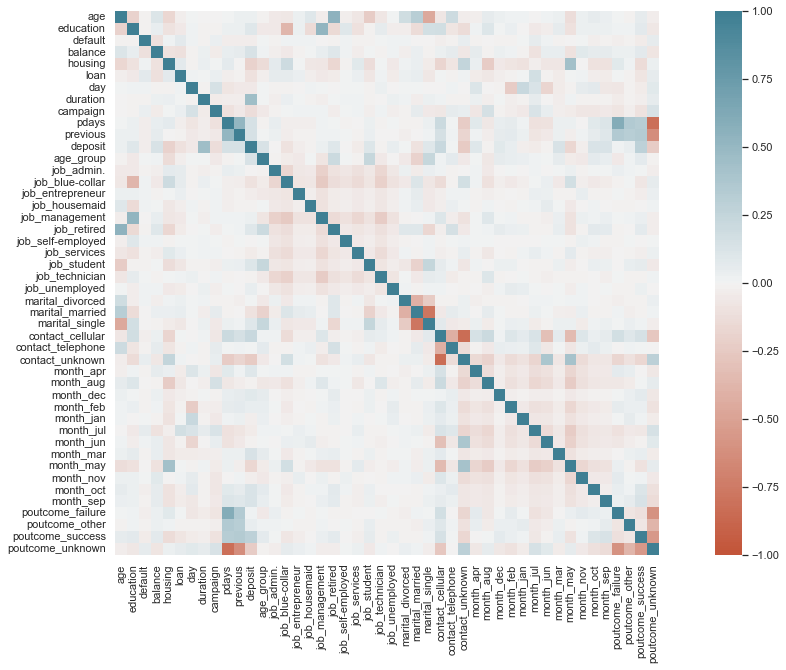

In [729]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = df.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:10, :]


Комментарий: признаков с корреляцией более 0.9 нет. Мультиколлинеарность отсутствует.



In [730]:
target_corr = corr['deposit'].reset_index()
target_corr = target_corr.sort_values('deposit', ascending=False)
target_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


#### Определим целевую переменную и предикторы

In [731]:
# зададим параметр random_state = 42, а размер тестовой выборки возьмите за 0.33.
X = df.drop(['deposit'], axis=1)
y = df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Отберем 15 наиболее значимых признака наилучшим образом подходящих для использования в задаче

In [734]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# Используем дисперсионный анализ ANOVA (f_classif)
best_features = SelectKBest(score_func=f_classif, k=15).fit(X_train, y_train)
features = best_features.get_feature_names_out()
features

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [735]:
X_train = X_train[features]
X_test = X_test[features]

#### Нормализация данных с помощью minmaxsxaler

In [736]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train) # обучаем на обущающей выборке
X_train_scaled = mm_scaler.transform(X_train) #преобразуем обучающую выборку
X_test_scaled = mm_scaler.transform(X_test) #преобразуем тестовую выборку


# 4. Логистическая регрессия и решающие деревья

### ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [737]:
# обучим логистическую регрессию и рассчитайте метрики качества
# В качестве алгоритма оптимизации будем использовать 'sag'
# в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)
log_reg.fit(X_train_scaled, y_train)
y_train_pred =log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))
print('-'*60)

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### ДЕРЕВО РЕШЕНИЙ

In [738]:
# обучим решающие деревья, настройте максимальную глубину
# качестве параметров для начала возьмём следующие: criterion = 'entropy', random_state = 42.
tree_sol = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
tree_sol.fit(X_train_scaled, y_train)
y_train_pred = tree_sol.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
print('-'*60)
y_test_pred = tree_sol.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Вывод: С параметрами по умолчанию модель становится переобученной

#### Переберем различные максимальные глубины деревьев и найдите глубину дерева

,depth,Accuracy_train,Accuracy_test
0,1,0.711521,0.706447
1,2,0.728804,0.717841
2,3,0.775775,0.770315
3,4,0.775923,0.769715
4,5,0.803840,0.793703
5,6,0.818021,0.806597
6,7,0.836632,0.814993
7,8,0.840916,0.812894
8,9,0.851403,0.806897
9,10,0.858936,0.800000


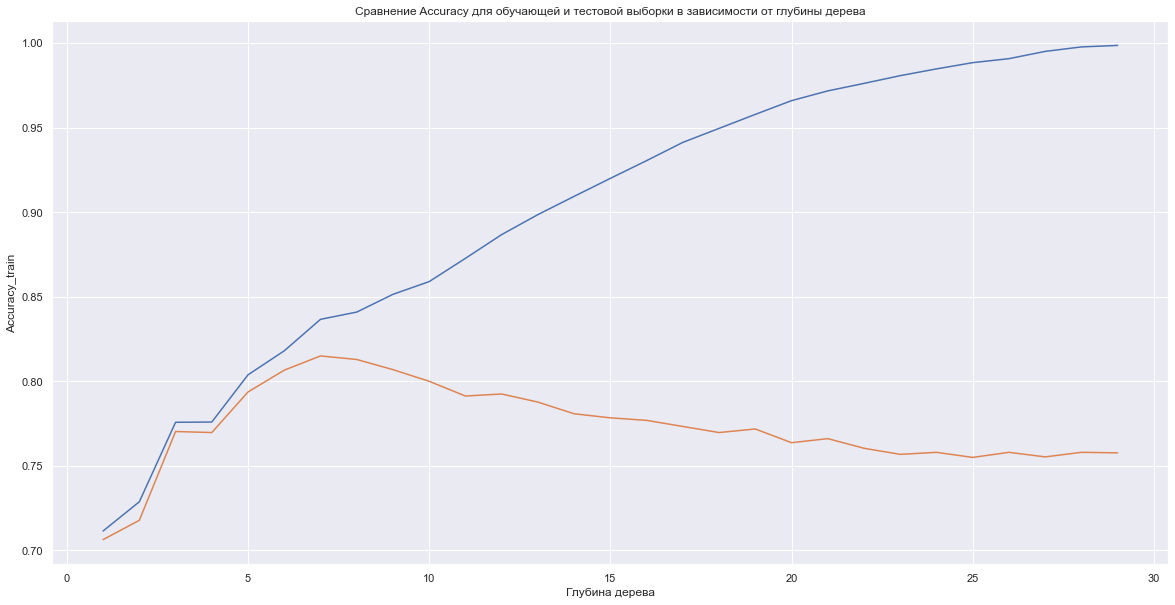

In [739]:
# Переберем различные максимальные глубины деревьев и найдите глубину дерева
# для которой будет максимальное значение метрики accuracy
# но при этом ещё не будет наблюдаться переобучения
n_list = []
acc_train = []
acc_test = []
for n in range(1, 30):
    tree_sol_1 = tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth=n
    )
    tree_sol_1.fit(X_train_scaled, y_train)
    y_train_pred_1 = tree_sol_1.predict(X_train_scaled)
    y_test_pred_1 = tree_sol_1.predict(X_test_scaled)
    n_list.append(n)
    acc_train.append(metrics.accuracy_score(y_train, y_train_pred_1))
    acc_test.append(metrics.accuracy_score(y_test, y_test_pred_1))
    
data_metrics = pd.DataFrame({
    'depth': n_list,
    'Accuracy_train': acc_train,
    'Accuracy_test': acc_test
})

# И сделаем визуализацию
ax = sns.lineplot(
    data=data_metrics,
    x = n_list,
    y = 'Accuracy_train'
)

ax = sns.lineplot(
    data=data_metrics,
    x = n_list,
    y = 'Accuracy_test',
    ax=ax
)
plt.title('Сравнение Accuracy для обучающей и тестовой выборки в зависимости от глубины дерева')
plt.xlabel('Глубина дерева')

data_metrics.iloc[:10,:]

Вывод: Видно, что при глубине дерева 6-7 наблюдается оптимальное соотношение accuracy между между обучающей и тестовой выборками

#### Подберем оптимальное значение гиперпараметров модели с помощью оптимизатора GridSearch

In [740]:
# подберем оптимальные параметры с помощью gridsearch
# перебрав следующие параметры: 'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]
gridS = tree.DecisionTreeClassifier(random_state=42)
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

model_grid = GridSearchCV(
    tree.DecisionTreeClassifier(),
    param_grid,
    scoring='f1',
    return_train_score=True
)
model_grid.fit(X_train_scaled, y_train)
print(f'Наилучшие значение параметров: {format(model_grid.best_params_)}')

y_test_pred = model_grid.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('-'*70)
print(metrics.classification_report(y_test, y_test_pred))

Наилучшие значение параметров: {'max_depth': 7, 'min_samples_split': 5}
f1_score на тестовом наборе: 0.8019
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



# 5. Ансамбли моделей и построение прогноза

#### Обучим случайный лес

In [741]:
# обучим на ваших данных случайный лес с параметрами
# n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10, random_state = 42.
RandomForest = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
RandomForest.fit(X_train_scaled, y_train)
y_train_pred = RandomForest.predict(X_train_scaled)
y_test_pred = RandomForest.predict(X_test_scaled)

print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('-'*30)
print('Recall на обучающей выборке: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('-'*30)
print('F1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Accuracy на обучающей выборке: 0.86
Accuracy на тестовой выборке: 0.83
------------------------------
Recall на обучающей выборке: 0.86
Recall на тестовой выборке: 0.83
------------------------------
F1 на обучающей выборке: 0.85
F1 на тестовой выборке: 0.82


#### Обучим Градиентный бустинг

In [742]:
# использум для классификации градиентный бустинг и сравните качество со случайным лесом
# с параметрами: learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42.
GradientBoosting = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
GradientBoosting.fit(X_train_scaled, y_train)
y_train_pred = GradientBoosting.predict(X_train_scaled)
y_test_pred = GradientBoosting.predict(X_test_scaled)

print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('-'*30)
print('Recall на обучающей выборке: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('-'*30)
print('F1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Accuracy на обучающей выборке: 0.89
Accuracy на тестовой выборке: 0.83
------------------------------
Recall на обучающей выборке: 0.89
Recall на тестовой выборке: 0.83
------------------------------
F1 на обучающей выборке: 0.88
F1 на тестовой выборке: 0.82


#### Стекинг

In [743]:
# объединим те алгоритмы скоторые применили в ходе данного проекта: решающие деревья, логистическую регрессию и градиентный бустинг
# В качестве метамодели используем модель логистической регрессии
meta_vodel = [
    ('DecisionTree', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6,
        random_state=42)),
    ('LogisticReg', linear_model.LogisticRegression(solver='sag', random_state=42)),
    ('GradientBoosting', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]
stacking_model = ensemble.StackingClassifier(
    meta_vodel,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stacking_model.fit(X_train_scaled, y_train)
y_train_pred = stacking_model.predict(X_train_scaled)
y_test_pred = stacking_model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Вывод: Интерпретация признаков в логистической регрессии сложна, поэтому посмотрим на дерево решений и градиентный бустинг на графиках.

#### Важность признаков в дереве решений

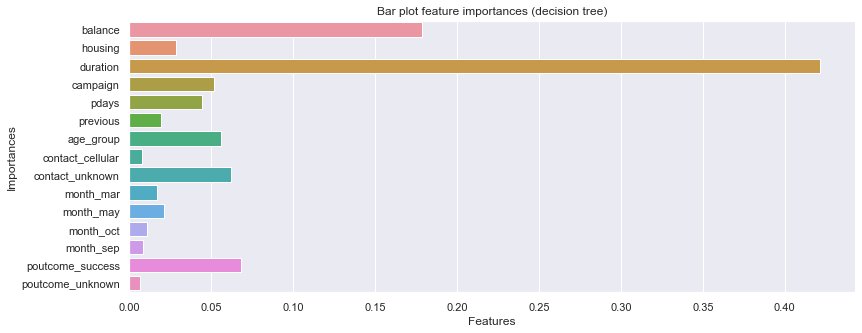

In [744]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки из тренировочного датафрейма до нормализации, так как нормализация возвращает numpy массив
feature_importances = tree_sol.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances (decision tree)')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

#### Важность признаков в градиентном бустинге

Text(0, 0.5, 'Importances')

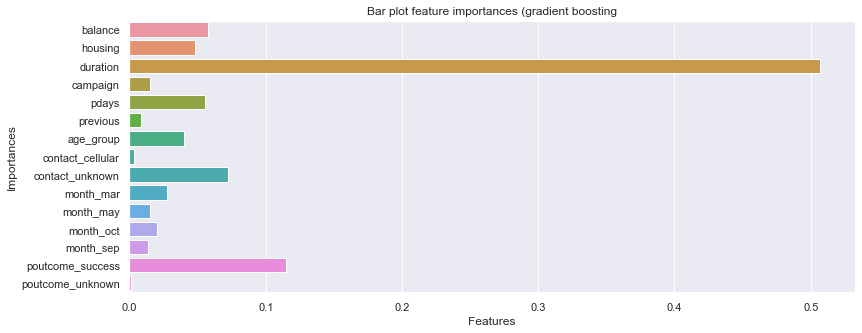

In [745]:
# Важность признаков в градиентном бустинге
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки из тренировочного датафрейма до нормализации, так как нормализация возвращает numpy массив
feature_importances = GradientBoosting.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances (gradient boosting')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')

Вывод: Наиболее важными признаками являются дерево решений являются: длительность контакта (duration), текущий баланс (balance),  результат предыдущей кампании (poutcome_success).
Для градиентного бустинка важными признаками являются: также duration, poutcome_success и определенности тип контакта (contact_unknown).

#### Оптимизации гиперпараметров — фреймворк Optuna

In [746]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
# задаем функцию 
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
study = optuna.create_study()

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# передаем в модель лучшие значения гиперпараметров
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)


y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('-'*30)
print('Recall на обучающей выборке: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('-'*30)
print('F1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 101, 'max_depth': 10, 'min_samples_leaf': 10}
Accuracy на обучающей выборке: 0.85
Accuracy на тестовой выборке: 0.82
------------------------------
Recall на обучающей выборке: 0.85
Recall на тестовой выборке: 0.83
------------------------------
F1 на обучающей выборке: 0.84
F1 на тестовой выборке: 0.81


Общий вывод:
В результате выполнения проекта были определены признаки, по которым можно выявить клиентов, более склонны к открытие депозита в банке. Были построены несколько моделей машинного обучения, которые подтверждают, воспользуется клиент открытием депозита или нет.

Портрет клиента: менеджеры и рабочие, женатые/замужем, со средним образованием, без просрочек, без заема на личные нужды. При этом около половины клиентов имеют кредит на жилье. Последний контакт часще всего происходил по мобильному телефону.

Также, более высокие шансы на открытие депозита у тех, кто ранее пользовался предложением банка, а также у клиентов до 30 лет или старше 65, с высшим образованием, неженатых, студентов или пенсионеров.

Наиболее сильная взаимосвязь с открытием депозита наблюдалась у переменных длительность контакта, наличие предыдущего позитивного опыта, факт звонка на мобильный телефон и количество дней, прошедших от контакта предыдущей кампании до контакта текущей кампании, что в последующем подтвердилось анализом значимых признаков для модели машинного обучения.

Были построены модели предсказания на основе логистической регрессии, дерева решений, а также ансамблевые модели: случайный лес, стекинг, градиентный бустинг над деревьями решений. Все они показали приблизительно похожий результат по метрикам Accuracy, Recall, F1. 
Можно рекомендовать использовать модель случайного леса после оптмизации гиперпараметров с помощью библиотеки OPTUNA (Accuracy 0.83, Recall 0.83, F1 0.82 на тестовой выборке).
